# Movie Recommendation System
We'll be using the MovieLens dataset to build a recommendation system using collaborative filtering and content-based filtering. Collaborative filtering is a technique that recommends items based on the preferences of similar users, while content-based filtering recommends items based on their attributes and features.

#### Steps for the project:
1. **Data Collection** Load the data from MovieLens dataset in a pandas DataFrame
2. **Data Preprocessing** Clean data by:
    * Check for missing values
    * Handle duplicate entries
    * Drop unnecessary columns
    * Merge the dataframes
3. **Data Analysis**
    * Calculate basic statistics (mean, median, standard deviation) of movie ratings.
    * Visualize the distribution of movie ratings.
    * Identify popular movies based on the number of ratings.
    * Build a recommendation system using collaborative filtering and content-based filtering.
4. **Model Evaluation**
    * Evaluate the performance of the recommendation system using RMSE (Root Mean Squared Error).
5. **Model Deployment**
    * Deploy the model using Flask and Streamlit.
    * Application should have endpoints for:
        * Accept user input for preferences (e.g., preferred genres, ratings).
        * Return movie recommendations based on the input using the recommendation algorithm
    * Test API using Postman.
    * Validate the API
6. Desploy in AWS
7. Documenting API and model

In [1]:
import pandas as pd

movies = pd.read_csv('data/movie.csv')
ratings = pd.read_csv('data/rating.csv')

### Data Preprocessing
Although dataset from kaggle has no duplicates and is highly optimized, we will just check if there is any missing values or duplicates. [Click here](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset/data?select=movie.csv) to check dataset


In [2]:
def check_missing(df):
    print(df.isnull().sum())
    print('-'*25)
    
def check_duplicates(df):
    print(df.duplicated().sum())
    
check_missing(movies)
check_duplicates(movies)

movieId    0
title      0
genres     0
dtype: int64
-------------------------
0


## Finding mean, median, mode of ratings

In [3]:
import numpy as np

# Calculate mean without built-in method
total_ratings = sum(ratings['rating'])
num_ratings = len(ratings['rating'])
mean_rating = total_ratings / num_ratings

# Calculate median without built-in method
sorted_ratings = sorted(ratings['rating'])
n = len(sorted_ratings)
if n % 2 == 0:
    median_rating = (sorted_ratings[n//2 - 1] + sorted_ratings[n//2]) / 2
else:
    median_rating = sorted_ratings[n//2]

# Calculate standard deviation without built-in method
squared_diffs = [(rating - mean_rating) ** 2 for rating in ratings['rating']]
squared_diffs_sum = sum(squared_diffs)
std_rating = np.sqrt(squared_diffs_sum / (num_ratings - 1))

print(f"Mean rating: {mean_rating:.2f}")
print(f"Median rating: {median_rating:.2f}")
print(f"Standard deviation of ratings: {std_rating:.2f}")

print('Comparing with built-in')
print(mean_rating == ratings['rating'].mean())
print(median_rating == ratings['rating'].median())
print(round(std_rating, 10) == round(ratings['rating'].std(), 10))

Mean rating: 3.53
Median rating: 3.50
Standard deviation of ratings: 1.05
Comparing with built-in
True
True
True


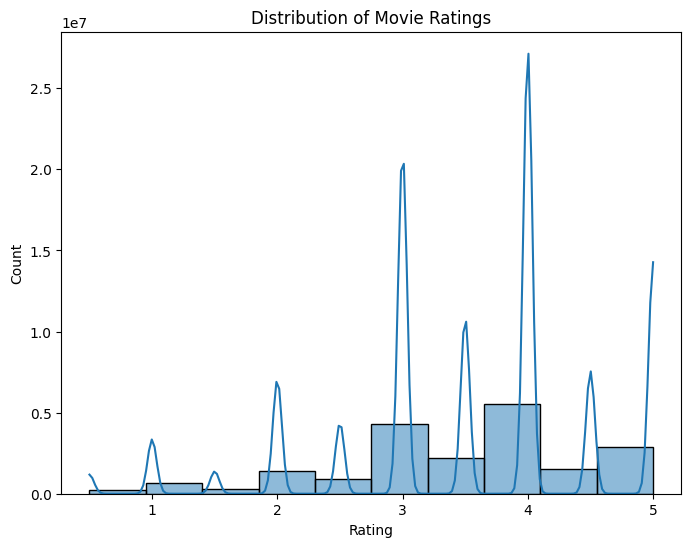

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(data=ratings, x='rating', bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Building search and recommendation

#### Building search

In [5]:
import re

def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

movies['clean_title'] = movies['title'].apply(clean_title)

In [6]:
# Building search function
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies['clean_title'])

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]
    
    return results

In [8]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value="Toy Story", 
    description="Movie Title: ",
    # disabled=False
)

movie_output = widgets.Output()

def on_type(data):
    with movie_output:
        movie_output.clear_output()
        title = data['new']
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')

display(movie_input, movie_output)

Text(value='Toy Story', description='Movie Title: ')

Output()

#### Visualizing ratings for movie

In [9]:
def visualize_movie_ratings(movie_id):
     # Filter the ratings for the specified movie
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    # Visualize the distribution of ratings
    plt.figure(figsize=(8, 6))
    sns.histplot(data=movie_ratings, bins=10, kde=True)
    plt.title(f"Distribution of Ratings for '{movies[movies['movieId'] == movie_id]['title'].values[0]}'")
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

In [10]:
movie_input = widgets.IntText(
    value=1,
    description='Movie ID:',
    disabled=False
)

visualization = widgets.Output()
button = widgets.Button(description='Visualize')

def on_button_click(btn):
    movie_id = movie_input.value
    with visualization:
        visualization.clear_output()
        if movie_id in movies['movieId'].values:
            visualize_movie_ratings(movie_id)
        else:
            print(f"No movie found with ID {movie_id}.")

button.on_click(on_button_click)
display(movie_input, button, visualization)

IntText(value=1, description='Movie ID:')

Button(description='Visualize', style=ButtonStyle())

Output()

#### Building recommention
First, by finding users who liked the same movie

In [11]:
movie_id = 1
# Finding users who watched and liked the movie by id
similar_users = ratings[(ratings['movieId'] == movie_id) & (ratings['rating'] > 4)]['userId'].unique() 
similar_users        

array([     6,     11,     14, ..., 138473, 138474, 138486], dtype=int64)

In [12]:
# Finding movies that similar users liked
similar_user_recs = ratings[(ratings['userId'].isin(similar_users)) & (ratings['rating'] > 4)]['movieId'] 
similar_user_recs

517             1
519             7
520            17
521            52
522            62
            ...  
19999505    53000
19999506    53953
19999507    54771
19999509    55282
19999510    56174
Name: movieId, Length: 1038237, dtype: int64

In [13]:
# Finding movies that 10% or more liked
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
similar_user_recs = similar_user_recs[similar_user_recs > .1]

similar_user_recs

movieId
1       1.000000
318     0.426600
260     0.395222
296     0.359822
356     0.340574
          ...   
778     0.101869
733     0.100631
2502    0.100631
2804    0.100384
1207    0.100136
Name: count, Length: 104, dtype: float64

##### Finding niches in how much all users like movies

In [14]:
all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] > 4)]

# Finding % of ALL users who liked the movie
all_user_recs = all_users['movieId'].value_counts() / len(all_users['userId'].unique())

all_user_recs

movieId
318     0.318561
296     0.279770
593     0.229719
527     0.220469
356     0.218255
          ...   
1580    0.047004
745     0.044837
551     0.044578
2804    0.042803
2355    0.027781
Name: count, Length: 104, dtype: float64

In [15]:
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ['similar', 'all']
rec_percentages

,similar,all
movieId,,
1,1.000000,0.126878
318,0.426600,0.318561
260,0.395222,0.216944
296,0.359822,0.279770
356,0.340574,0.218255
...,...,...
778,0.101869,0.071778
733,0.100631,0.052768
2502,0.100631,0.059913


We want to have a big difference between people with similar interest than people in general, so we can niche down by assigning a score to each recommended movie, ultimately allowing us to rank the recommendations and present the most relevant ones to the user.

The core idea is to compare how often users similar to the target user tend to like a particular movie compared to how often the movie is generally liked by all users. Movies that get a thumbs up from users with similar tastes are considered more relevant recommendations and therefore receive a higher score.

In [16]:
# Creating a score column based on the ratio between similar users and in general liked a movie
rec_percentages['score'] = rec_percentages['similar'] / rec_percentages['all']
rec_percentages = rec_percentages.sort_values('score', ascending=False)
rec_percentages 

,similar,all,score
movieId,,,
1,1.000000,0.126878,7.881607
3114,0.269031,0.055484,4.848761
2355,0.116351,0.027781,4.188078
4886,0.189256,0.057903,3.268505
6377,0.189751,0.060918,3.114850
...,...,...,...
296,0.359822,0.279770,1.286134
858,0.256220,0.200352,1.278850
2858,0.222057,0.174455,1.272863


In [17]:
rec_percentages.head(10).merge(movies, left_index=True, right_on='movieId')

,similar,all,score,movieId,title,genres,clean_title
0,1.000000,0.126878,7.881607,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
3027,0.269031,0.055484,4.848761,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 2 1999
2270,0.116351,0.027781,4.188078,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,Bugs Life A 1998
4790,0.189256,0.057903,3.268505,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,Monsters Inc 2001
6271,0.189751,0.060918,3.114850,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,Finding Nemo 2003
582,0.212774,0.071731,2.966280,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,Aladdin 1992
8278,0.160045,0.054511,2.936018,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,Incredibles The 2004
589,0.188390,0.067389,2.795573,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,Beauty and the Beast 1991
360,0.231279,0.084640,2.732495,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,Lion King The 1994
1052,0.151133,0.057463,2.630074,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,Willy Wonka the Chocolate Factory 1971


#### Merging all the logic done so far into a function:

In [18]:
def find_similar_movies(movie_id):
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4.5)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.5)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

    similar_user_recs = similar_user_recs[similar_user_recs > .10]
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]

In [19]:
# Widget for recommending
movie_name_input = widgets.Text(
    value="",
    description="Movie Title:"
)

recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data['new']
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]['movieId']
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')
display(movie_name_input, recommendation_list)

Text(value='', description='Movie Title:')

Output()